# 3. Parameter estimation

This notebook introduces the `Estimator` class and demonstrates it's functions for paramater estimation using the example of a simple batch model (see Notebook [1. Modeling & Simulation](1.%20Modeling%20&%20Simulation.ipynb)). 

#### Import dependencies

In [1]:
import sys 
sys.path.append(r'..')

from estim8.models import FmuModel
from estim8 import visualization, datatypes, Estimator
import pandas as pd

## 1. Load the `SimpleBatch` FMU model

In [2]:
SimpleBatchModel = FmuModel(path=r'../tests/test_data/SimpleBatch.fmu')
print(f"Model parameters: \n {SimpleBatchModel.parameters}")
print(f"Model observables: \n {SimpleBatchModel.observables}")

Model parameters: 
 {'Ks': 0.01, 'S0': 10.0, 'X0': 0.2, 'Y_XS': 0.35, 'mu_max': 0.4}
Model observables: 
 ['S', 'X', 'der(S)', 'der(X)', 'mu']


## 2. Load experimental data & datastructure setup
In order to setup an `Experiment` datastructure (see [Notebook 2](2.%20Experimental%20data%20and%20error%20modeling.ipynb)), raw measurement data is loaded first. Here, the function `pandas.read_excel` is used to read the contents of an Excel sheet _SimpleBatch_Data.xlsx_, which contains artificial measurements for biomass concentration `X` $[g \cdot L^{-1}]$ and substrate concentration `S` $[g \cdot L^{-1}]$ over the duration of a batch cultivation.

In [3]:
# import datasheet
data = pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0, header=(0,1))
data.head(11)

Time,X,S
h,g/L,g/L
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN
0.5,0.268477,NaN
0.6,0.312500,NaN
0.7,0.150687,NaN
0.8,0.226870,NaN


Before creating an `Experiment` object by passing the created `DataFrame`, the multi-index must be removed. 

For this simple example no we assume the `Experiment`'s default `LinearErrorModel` to describe the noises of `Measurement`s (see Notebook [2. Experimental data and error modeling](2.%20Experimental%20data%20and%20error%20modeling.ipynb)). As the names of the columns in `data` directly correspond to the states in `SimpleBatchModel.observables` no `observation_mapping` must be defined.

In [4]:
# drop the multi-index header and show resulting dataframe
data.columns = data.columns.droplevel(1)
display(data)

# create an Experiment object
experiment = datatypes.Experiment(data) 

Time,X,S
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN
...,...,...
9.6,4.885956,NaN
9.7,4.807351,NaN
9.8,5.167874,NaN
9.9,5.220779,NaN


To compare the unfitted model's precitions to experimental data, the `plot_simulation` function of the `visualization` submodule takes a keyword argument experiment.

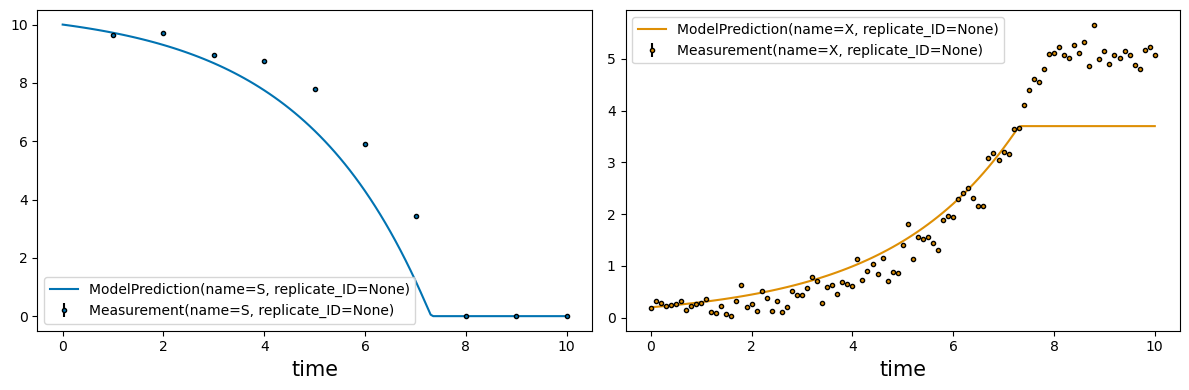

In [5]:
# compare simulation to data
simulation = SimpleBatchModel.simulate(t0=0, t_end=10, stepsize=0.1)
_ = visualization.plot_simulation(simulation=simulation, experiment=experiment, observe=['S', 'X'])

## 3. Problem definition
Besides a model for forward simulation and experimental data, an estimation problem is defined by unknown parameters and and their bounds using a `dictionary`. 

In [6]:
## define unknown parameters with upper and lower bounds
bounds = {
    'X0': [0.05, 0.15],
    'mu_max': [0.1, 0.9],
    'Y_XS': [0.1, 1]
}

## 4. The `Estimator` class

The `Estimator` class collects all single parts of a problem defined by the user and manages the processes of model fitting. Creating an instance of this class requires the following arguments:

| Argument | Type | Description |
|----------|------|-------------|
| model | models.Estim8Model | The model class to be fitted. Must be a subclass of Estim8Model that runs the simulations. |
| bounds | dict[str, List[float]] | Dictionary defining the parameter bounds for estimation. Format: {"param_name": [lower_bound, upper_bound]}. |
| data | Experiment \| Dict[str, Experiment] | Experimental data for model fitting. Can be single experiment or multiple replicates as Experiment objects in form of dict{replicate_ID: Experiment}.|

Optional keyword arguments are:

| Kwarg | Type | Description |
|----------|------|-------------|
| t | List[float], optional | Time vector specification as [t_0, t_end, step_size]. If None, will be automatically determined from the experimental data |
| metric | Literal["SS", "WSS", "negLL"], optional | Loss function for optimization: "SS" (Sum of squared residuals), "WSS" (Weighted sum of squared residuals), or "negLL" (Negative log-likelihood). Default is "SS" |
| parameter_mapping | List[ParameterMapper] \| ParameterMapping, optional | Defines parameter relationships between replicates. Can be list of mappings or complete ParameterMapping object. None means all parameters applied to all model replicates (default) |

In [7]:
# Instantiating an Estimator object
estimator = Estimator(
    model=SimpleBatchModel,     # model used for simulation
    bounds=bounds,              # unknown parameters and bounds
    data=experiment,            # experimental data
    t=[0, 10, 0.1],             # the timeframe for model simulation as [t_0, t_end, step_size],
    metric = 'SS'               # default objective function Sum of squared residuals
)

### 4.1 Parameter estimation
`Estim8` supports a variety of optimzation algorithms from [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html), [`scikit-optimize`](https://scikit-optimize.github.io/stable/) and [`pygmo`](https://esa.github.io/pygmo2/index.html). Is is higly recommended to check out their documentations, e.g. for the use of solver hyperparameters and keyword arguments. 

The optimization algorithm of choice is specified by passing a corresponding method key to the function `Estimator.estimate`. 

### 4.1.1 scipy and scikit-optimize alogorithms and keys: 

| Method key         | Optimization function          | Solver parallelization |
|-----------------|-----------------------------------|------------------------|
| local           | [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)         | ❌                  |
| de              | [`scipy.optimize.differential_evolution`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) | ✅               |
| bh              | [`scipy.optimize.basinhopping`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html)     |❌                  |
| shgo            | [`scipy.optimize.shgo`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html)             |✅               |
| dual_annealing  | [`scipy.optimize.dual_annealing`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html)   |❌                  |
| gp              | [`skopt.gp_minimize`](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html)               |✅               |


In this example, the `differential_evolution` function from `scipy`.optimize is used to solve the estimation problem.
 
The estimation is started by calling the function `Estimator.estimate`. It takes at least the following arguments:

| Argument | Type | Description |
|----------|------|-------------|
| method   | str or List[str] | the method key of the optimization algorithm. Pygmo algorithms are passed as a List[str] (see below). |
| max_iter | int  | maximum iteration rounds for the solver algorithm |

Additionally, keyword arguments include:

| Kwarg | Type | Description |
|----------|------|-------------|
| n_jobs   | int | number of parallel jobs to run the optimization algorithm with. |
| optimizer_kwargs | dict  | keyword arguments for the optimization function |

Finally, the `Estimator.estimate` method returns the estimated parameters and an info-object containing additional information about the optimization procedure. 

In [ ]:
estimates, info = estimator.estimate(
    method              =   'de',           # method key of the optimization algorithm
    max_iter            =   1000,           # maximum number of iterations for the solver
    n_jobs              =   1,              # process pool size of the solver algorithm     
    optimizer_kwargs    =   {               # kewyword arguments to pass to the differential_evolution function:
                'disp': True,               # prints the evolution process
                "x0": [0.15, 0.3, 0.4],     # initial guess for the unknown parameters
                "popsize": 15,              # population size
            }
)

print(f" \nEstimated parameters: \n{estimates}")
print(f"Estimation info: \n{info}")

differential_evolution step 1: f(x)= 13.893455362916825
differential_evolution step 2: f(x)= 13.893455362916825
differential_evolution step 3: f(x)= 6.830642540502671
differential_evolution step 4: f(x)= 6.830642540502671
differential_evolution step 5: f(x)= 6.830642540502671
differential_evolution step 6: f(x)= 4.615935150075668
differential_evolution step 7: f(x)= 4.173564731276754
differential_evolution step 8: f(x)= 4.173564731276754
differential_evolution step 9: f(x)= 4.048358143632805
differential_evolution step 10: f(x)= 4.014146922760954
differential_evolution step 11: f(x)= 3.9301128385620903
differential_evolution step 12: f(x)= 3.9301128385620903
differential_evolution step 13: f(x)= 3.9301128385620903
differential_evolution step 14: f(x)= 3.903296882429758
differential_evolution step 15: f(x)= 3.8926716961752135
differential_evolution step 16: f(x)= 3.857857991186739
differential_evolution step 17: f(x)= 3.851115617410295
differential_evolution step 18: f(x)= 3.85111561741

#### Visualizing estimation results

To inspect the optimization results. the `plot_estimates` function from the `visualization` submodule convenient plots:

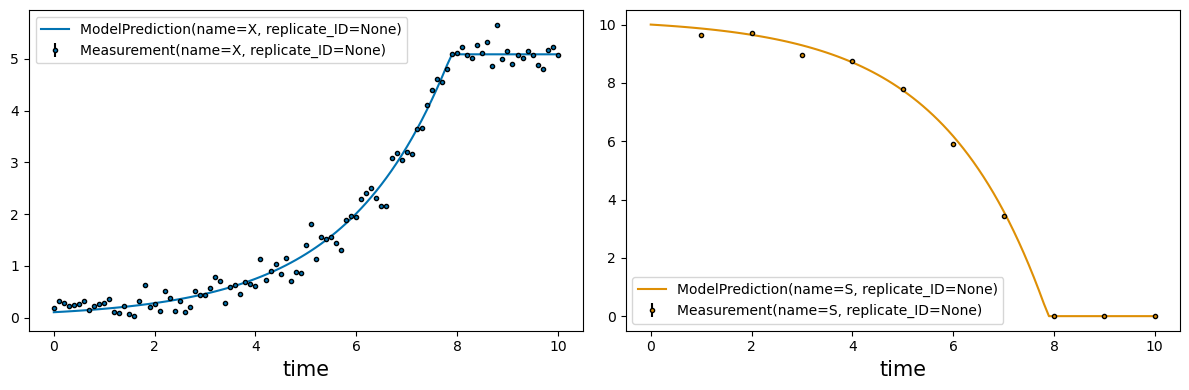

In [18]:
# compare fitted model to data
_ = visualization.plot_estimates(estimates=estimates, estimator=estimator, only_measured=True)

### Parallelized parameter estimation

In many cases the parameter estimation time can be reduced by parallelizing the optimization function using multiple CPUs. In this example, 4 parallel jobs are used for the differential evolution algorithm by setting `n_jobs=4` when calling the `estimate` function:

In [19]:
estimates, info = estimator.estimate(
    method              =   'de',           # method key of the optimization algorithm
    max_iter            =   1000,           # maximum number of iterations for the solver
    n_jobs              =   4,              # process pool size of the solver algorithm     
    optimizer_kwargs    =   {               # kewyword arguments to pass to the differential_evolution function:
                'disp': True,               # prints the evolution process
                "x0": [0.15, 0.3, 0.4],     # initial guess for the unknown parameters
                "popsize": 15,              # population size
            }
)

c:\Users\Tobia\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 8.291639857275882
differential_evolution step 2: f(x)= 8.291639857275882
differential_evolution step 3: f(x)= 8.291639857275882
differential_evolution step 4: f(x)= 8.291639857275882
differential_evolution step 5: f(x)= 7.34685975323019
differential_evolution step 6: f(x)= 5.3199861977186025
differential_evolution step 7: f(x)= 5.253152019981663
differential_evolution step 8: f(x)= 4.764164748300784
differential_evolution step 9: f(x)= 4.764164748300784
differential_evolution step 10: f(x)= 4.764164748300784
differential_evolution step 11: f(x)= 4.764164748300784
differential_evolution step 12: f(x)= 4.764164748300784
differential_evolution step 13: f(x)= 4.2971191965487066
differential_evolution step 14: f(x)= 4.2971191965487066
differential_evolution step 15: f(x)= 4.2302778526428995
differential_evolution step 16: f(x)= 3.9892198941767694
differential_evolution step 17: f(x)= 3.871936483096647
differential_evolution step 18: f(x)= 3.8719364830966

### Advanced parameter estimation with `pygmo`

`pygmo` is a scientific Python library for massively parallel optimization, implementing a range of state-of-the-art bio-inspired and evolutionary algorithms. Using the [asynchronous, generalized islands model](generalizedIslandsref), these algorithms can be easily mixed, yielding a "super algorithm" that exploits algorithmic cooperation. `estim8` features the following algorithms: 

| method key                | algorithm                                         |
|------------------------|-----------------------------------------------------|
| [scipy_optimize](https://esa.github.io/pygmo2/algorithms.html#pygmo.scipy_optimize)          | A wrapper around `scipy.optimize.minimize`          |
| [de1220](https://esa.github.io/pygmo2/algorithms.html#pygmo.de1220)                 | Self-adaptive Differential Evolution, pygmo flavour (pDE) |
| [bee_colony](https://esa.github.io/pygmo2/algorithms.html#pygmo.bee_colony)             | Artificial Bee Colony                               |
| [gaco](https://esa.github.io/pygmo2/algorithms.html#pygmo.gaco)                   | Extended Ant Colony Optimization algorithm          |
| [pso](https://esa.github.io/pygmo2/algorithms.html#pygmo.pso)                    | Particle Swarm Optimization                         |
| [sga](https://esa.github.io/pygmo2/algorithms.html#pygmo.sga)                    | A Simple Genetic Algorithm                          |
| [sea](https://esa.github.io/pygmo2/algorithms.html#pygmo.sea)                    | (N+1)-ES simple evolutionary algorithm              |
| [compass_search](https://esa.github.io/pygmo2/algorithms.html#pygmo.compass_search)          | Compass Search                                      |
| [gwo](https://esa.github.io/pygmo2/algorithms.html#pygmo.gwo)                    | Grey Wolf Optimizer (gwo)                           |
| [cmaes](https://esa.github.io/pygmo2/algorithms.html#pygmo.cmaes)                  | Covariance Matrix Evolutionary Strategy (CMA-ES)     |
| [simulated_annealing](https://esa.github.io/pygmo2/algorithms.html#pygmo.simulated_annealing)     | Simulated Annealing (Corana’s version)              |
| [nsga2](https://esa.github.io/pygmo2/algorithms.html#pygmo.nsga2)                  | Non dominated Sorting Genetic Algorithm (NSGA-II)    |
| [mbh](https://esa.github.io/pygmo2/algorithms.html#pygmo.mbh)                    | Monotonic Basin Hopping (generalized)               |
| [ihs](https://esa.github.io/pygmo2/algorithms.html#pygmo.ihs)                    | Improved harmony search algorithm                   |
| [xnes](https://esa.github.io/pygmo2/algorithms.html#pygmo.xnes)                   | Exponential Evolution Strategies                    |
| [de](https://esa.github.io/pygmo2/algorithms.html#pygmo.de)                     | Differential Evolution                              |

For using `pygmo`'s Generalized Islands approach, the `estimate` function is called with a `list` of algorithms keys in the `method` argument. 

[generalizedIslandsref]:https://link.springer.com/chapter/10.1007/978-3-642-28789-3_7



In [ ]:
estimates, info = estimator.estimate(
    method=['sga', 'pso', 'de1220', 'sea'],         # algorithms for islands
    n_jobs=4,                                       # process pool size of the solver algorithm
    max_iter=10,                                    # number of evolutions
    optimizer_kwargs = {
        'pop_size': 30,                             # population size of each island
    }
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    8.6s finished


>>> Created Island 1 using <pygmo.core.sga object at 0x000001E066904F30>
>>> Created Island 2 using <pygmo.core.sga object at 0x000001E066904430>
>>> Created Island 3 using <pygmo.core.sga object at 0x000001E066905E70>
>>> Created Island 4 using <pygmo.core.sga object at 0x000001E066907B30>


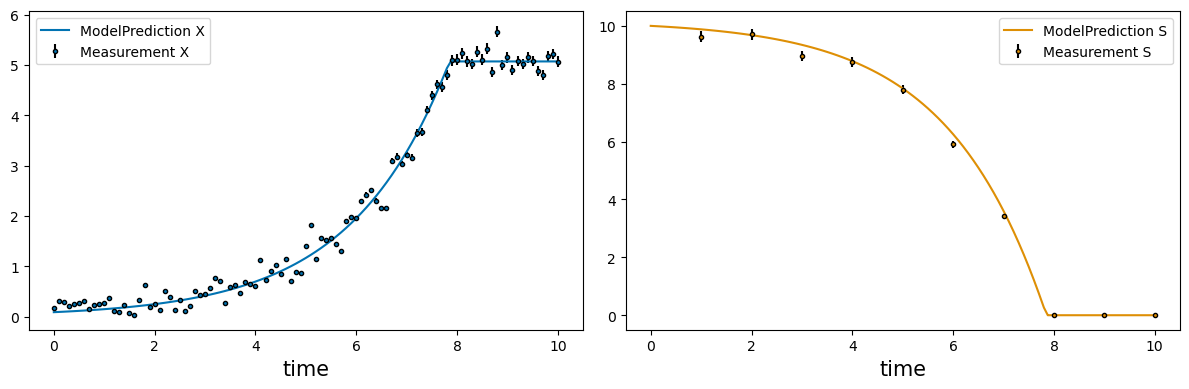

In [14]:
# compare fitted model to data
_ = visualization.plot_estimates(estimates=estimates, estimator=estimator, only_measured=True)